In [1]:
import time

import numpy as np
import pandas as pd
from checkers import *
from heuristic import *

# from minimax_alphabeta import *
from minimax_alphabeta import AI
from util.helpers import *

In [2]:
def generate_samples(N, depth):
    samples = []
    for _ in range(N):
        WP, BP, K = get_fresh_board()
        player = random.choice([PlayerTurn.WHITE, PlayerTurn.BLACK])
        # print(f"Player NOT moving first: {player}")
        for _ in range(0, random.randint(1, depth)):
            player = switch_player(player)  # Switch to opponent's turn
            lm = generate_legal_moves(WP, BP, K, player)
            if not lm:
                break  # Current player ran out of legal moves. Game over.
            else:
                # print(f"Player {player} has {len(lm)} legal moves. the moves are {lm}")
                pass

            WP, BP, K = do_move(
                WP, BP, K, random.choice(lm), player=player
            )  # Do a random legal move

        lm = generate_legal_moves(WP, BP, K, player)

        samples.append(
            (
                WP,
                BP,
                K,
                0 if player == PlayerTurn.WHITE else 1,  # 0 for white, 1 for black
                lm,  # none if game is over
            )
        )
    return samples

In [3]:
N = 100
samples_to_1 = generate_samples(N, depth=1)
samples_to_2 = generate_samples(N, depth=2)
samples_to_5 = generate_samples(N, depth=3)
samples_to_10 = generate_samples(N, depth=10)
samples_to_20 = generate_samples(N, depth=20)
samples_to_40 = generate_samples(N, depth=40)
samples_to_50 = generate_samples(N, depth=50)
samples_to_60 = generate_samples(N, depth=60)
samples_to_80 = generate_samples(N, depth=80)
samples_to_100 = generate_samples(10 * N, depth=100)
samples_to_150 = generate_samples(5 * N, depth=150)


X = (
    samples_to_1
    + samples_to_2
    + samples_to_5
    + samples_to_10
    + samples_to_20
    + samples_to_40
    + samples_to_60
    + samples_to_80
    + samples_to_100
    + samples_to_150
)
Y = [
    smart(*tup, 0, (tup[0], tup[1], tup[2])) for tup in X
]  # depth 0 and global board state matches current board state

X = [(tup[0], tup[1], tup[2], tup[3], len(tup[4]) if tup[4] is not None else 0) for tup in X]

print(X)
print(Y)

[(4293918720, 7935, 0, 1, 8), (4292935680, 4095, 0, 0, 8), (4293918720, 11775, 0, 1, 8), (4291952640, 4095, 0, 0, 8), (4289986560, 4095, 0, 0, 8), (4293918720, 7679, 0, 1, 8), (4289986560, 4095, 0, 0, 8), (4292083712, 4095, 0, 0, 8), (4292935680, 4095, 0, 0, 8), (4293001216, 4095, 0, 0, 8), (4292935680, 4095, 0, 0, 8), (4293918720, 7935, 0, 1, 8), (4292083712, 4095, 0, 0, 8), (4293918720, 19455, 0, 1, 8), (4292083712, 4095, 0, 0, 8), (4286054400, 4095, 0, 0, 8), (4291952640, 4095, 0, 0, 8), (4291952640, 4095, 0, 0, 8), (4286054400, 4095, 0, 0, 8), (4293918720, 7935, 0, 1, 8), (4291952640, 4095, 0, 0, 8), (4293918720, 34815, 0, 1, 8), (4293918720, 11263, 0, 1, 8), (4293918720, 11263, 0, 1, 8), (4293918720, 7935, 0, 1, 8), (4292935680, 4095, 0, 0, 8), (4289986560, 4095, 0, 0, 8), (4292935680, 4095, 0, 0, 8), (4292935680, 4095, 0, 0, 8), (4292935680, 4095, 0, 0, 8), (4293001216, 4095, 0, 0, 8), (4293918720, 11263, 0, 1, 8), (4289986560, 4095, 0, 0, 8), (4292083712, 4095, 0, 0, 8), (429391

In [4]:
def prepare_sample(sample):
    WP, BP, K, player_turn, num_legal_moves = sample
    # return WP_binary + BP_binary + K_binary + [player_turn, num_legal_moves] + [count_bits(WP)] + [count_bits(BP)] + [count_bits(WP & K)] + [count_bits(BP & K)]
    return (
        [WP]
        + [BP]
        + [K]
        + [player_turn]
        + [count_bits(WP)]
        + [count_bits(BP)]
        + [count_bits(WP & K)]
        + [count_bits(BP & K)]
    )


# Prepare all samples
X_processed = [prepare_sample(sample) for sample in X]

X = X_processed

print(X[12])
print(Y[12])


[4292083712, 4095, 0, 0, 12, 12, 0, 0]
-22


In [5]:
import plotly.graph_objects as go
import numpy as np

X_sample = np.array(X)
Y_sample = np.array(Y)

wp_minus_bp = X_sample[:, 4] - X_sample[:, 5]
wk_minus_bk = X_sample[:, 6] - X_sample[:, 7]
eval_scores = Y_sample
colors = ["blue" if turn == 0 else "red" for turn in X_sample[:, 3]]


custom_hover_text = [
    get_ascii_board(WP, BP, K)
    for WP, BP, K in zip(X_sample[:, 0], X_sample[:, 1], X_sample[:, 2])
]

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=wp_minus_bp,
            y=wk_minus_bk,
            z=eval_scores,
            mode="markers",
            marker=dict(size=5, color=colors),
            text=custom_hover_text,  # Set custom hover text
            hoverinfo="text",  # Display only the custom text on hover
        )
    ]
)

fig.update_layout(
    scene=dict(
        xaxis_title="# White Pawns - # Black Pawns",
        yaxis_title="# White Kings - # Black Kings",
        zaxis_title="Evaluation Score",
    ),
    title="3D Scatter Plot of Evaluation vs Number of Pawns",
    width=800,  # Width of the plot window
    height=600,  # Height of the plot window
    margin=dict(l=0, r=0, b=0, t=0),  # Adjust margins (left, right, bottom, top)
)

fig.show()

Length of X: 2300
Length of Y: 2300
Number of features in each sample of X: 8
Average value of Y: -13.33
Maximum value in Y: 1248
Minimum value in Y: -1268
Number of games that ended with white to move: 329
Number of games that ended with black to move: 1


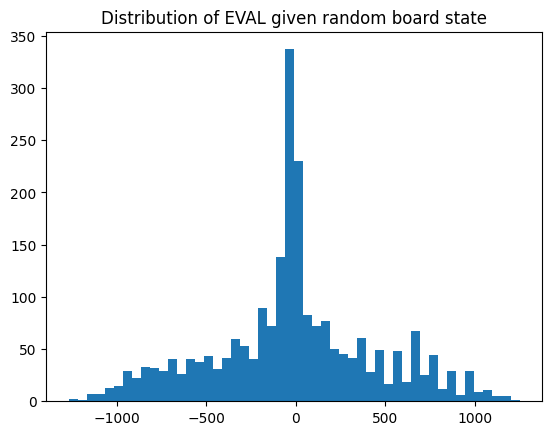

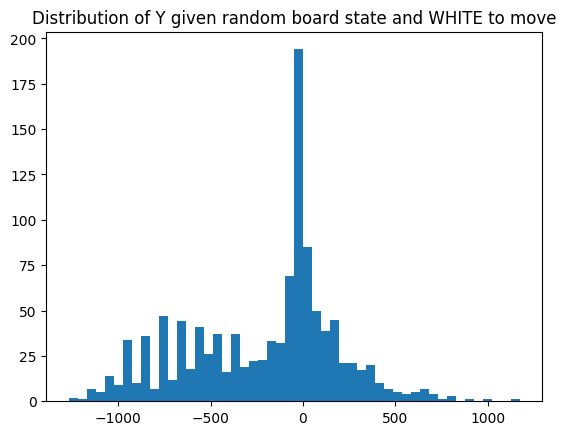

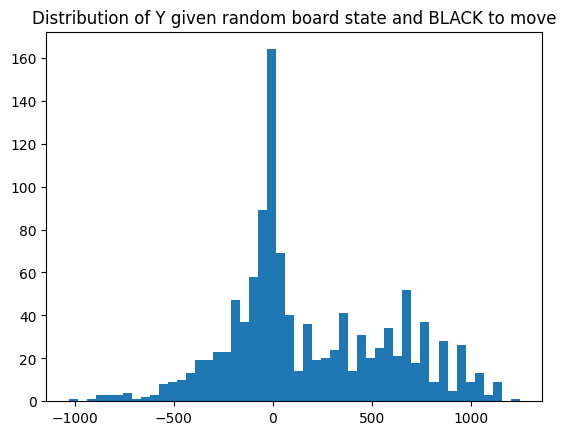

In [6]:
print(f"Length of X: {len(X)}")
print(f"Length of Y: {len(Y)}")
print(f"Number of features in each sample of X: {len(X[0])}")
print(f"Average value of Y: {sum(Y) / len(Y):.2f}")
print(f"Maximum value in Y: {max(Y)}")
print(f"Minimum value in Y: {min(Y)}")

# number of games that ended with white to move (0) and black to move (1)
print(
    f"Number of games that ended with white to move: {len([y for i, y in enumerate(Y) if X[i][0] == 0])}"
)

print(
    f"Number of games that ended with black to move: {len([y for i, y in enumerate(Y) if X[i][0] == 1])}"
)

import matplotlib.pyplot as plt

plt.title("Distribution of EVAL given random board state")
plt.hist(Y, bins=50)
plt.show()

# make two seperate of histograms for Y grouped by player turn
plt.title("Distribution of Y given random board state and WHITE to move")
plt.hist([y for i, y in enumerate(Y) if X[i][3] == 0], bins=50)
plt.show()

plt.title("Distribution of Y given random board state and BLACK to move")
plt.hist([y for i, y in enumerate(Y) if X[i][3] == 1], bins=50)
plt.show()

In [165]:
def bitboard_to_2d_array(WP, BP, K):
    board = np.zeros((8, 8), dtype=int)

    for row in range(8):
        for col in range(8):
            if row % 2 != col % 2:  # Only consider playable squares
                index = (7 - row) * 4 + (col // 2)
                if WP & (1 << index):
                    board[row, col] = 3 if K & (1 << index) else 1  # White king or pawn
                elif BP & (1 << index):
                    board[row, col] = 4 if K & (1 << index) else 2  # Black king or pawn
    return board

In [166]:
# Create a DataFrame from X
df = pd.DataFrame(
    X,
    columns=[
        "WP",
        "BP",
        "K",
        "player_turn",
        "count_bits(WP)",
        "count_bits(BP)",
        "count_bits(WP & K)",
        "count_bits(BP & K)",
    ],
)

df["2d-Board"] = df.apply(
    lambda row: bitboard_to_2d_array(row["WP"], row["BP"], row["K"]), axis=1
)


# Add EVAL as a column to the DataFrame
df["EVAL"] = Y

cols = ["EVAL"] + [col for col in df if col != "EVAL"]
df = df[cols]


In [167]:
df

,EVAL,WP,BP,K,player_turn,count_bits(WP),count_bits(BP),count_bits(WP & K),count_bits(BP & K),2d-Board
0,-20,4293918720,19455,0,1,12,12,0,0,"[[0, 1, 0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, ..."
1,-50,4293918720,18431,0,1,12,12,0,0,"[[0, 1, 0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, ..."
2,-26,4293918720,11775,0,1,12,12,0,0,"[[0, 1, 0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, ..."
3,31,4293001216,4095,0,0,12,12,0,0,"[[0, 1, 0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, ..."
4,11,4293918720,7679,0,1,12,12,0,0,"[[0, 1, 0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0, ..."
...,...,...,...,...,...,...,...,...,...,...
22995,-595,256,1107296402,1107296256,0,1,5,0,2,"[[0, 0, 0, 0, 0, 4, 0, 0], [0, 0, 4, 0, 0, 0, ..."
22996,488,1789919241,262580,9,1,9,6,2,0,"[[0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 1, 0, 0, 0, ..."
22997,-369,3674341376,67174847,0,0,7,10,0,0,"[[0, 1, 0, 0, 0, 1, 0, 1], [1, 0, 1, 0, 2, 0, ..."
22998,265,8389640,4096,5128,0,3,1,2,1,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ..."


In [168]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23000 entries, 0 to 22999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   EVAL                23000 non-null  int64 
 1   WP                  23000 non-null  int64 
 2   BP                  23000 non-null  int64 
 3   K                   23000 non-null  int64 
 4   player_turn         23000 non-null  int64 
 5   count_bits(WP)      23000 non-null  int64 
 6   count_bits(BP)      23000 non-null  int64 
 7   count_bits(WP & K)  23000 non-null  int64 
 8   count_bits(BP & K)  23000 non-null  int64 
 9   2d-Board            23000 non-null  object
dtypes: int64(9), object(1)
memory usage: 1.8+ MB
None


In [169]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CheckersCNN(nn.Module):
    def __init__(self):
        super(CheckersCNN, self).__init__()
        # Convolutional layers for processing the 2D board
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Fully connected layers for combining 2D board features with other features
        self.fc1 = nn.Linear(64 * 8 * 8 + 5, 128)  # Adjust the size based on your input dimensions
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, board, features):
        # Process the 2D board
        x = F.relu(self.conv1(board))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten the output

        # Combine with other features
        x = torch.cat((x, features), dim=1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Linear activation for the output layer
        return x


In [170]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and CheckersCNN is your model class


# Custom Dataset
class CheckersDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Convert the 2D board into a tensor
        board = torch.tensor(row["2d-Board"], dtype=torch.float32).unsqueeze(
            0
        )  # Add channel dimension

        # Extract other features and convert to tensor
        features = torch.tensor(
            [
                row["player_turn"],
                row["count_bits(WP)"],
                row["count_bits(BP)"],
                row["count_bits(WP & K)"],
                row["count_bits(BP & K)"],
            ],
            dtype=torch.float32,
        )

        # Target variable
        eval = torch.tensor(row["EVAL"], dtype=torch.float32)
        return board, features, eval


# Split the data
train_df, val_df = train_test_split(df, test_size=0.2)
train_dataset = CheckersDataset(train_df)
val_dataset = CheckersDataset(val_df)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Model, Loss, Optimizer
model = CheckersCNN()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.0001)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for board, features, eval in train_loader:
        optimizer.zero_grad()
        outputs = model(board, features)
        loss = criterion(outputs.squeeze(), eval)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for board, features, eval in val_loader:
            outputs = model(board, features)
            val_loss += criterion(outputs.squeeze(), eval).item()

    # Print epoch results
    print(
        f"Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss/len(val_loader)}"
    )

    example_board, example_features, example_eval = next(iter(val_loader))
    random_idx = torch.randint(0, example_board.size(0), (1,)).item()  # Random index
    example_output = model(example_board, example_features).squeeze()[random_idx]
    print(
        f"Random Example True EVAL: {example_eval[random_idx].item()}, Predicted EVAL: {example_output.item()}"
    )

Epoch 1/100, Training Loss: 9375.04296875, Validation Loss: 14313.199140760633
Random Example True EVAL: -12.0, Predicted EVAL: 4.282829761505127
Epoch 2/100, Training Loss: 1897.11083984375, Validation Loss: 2320.2971115112305
Random Example True EVAL: -52.0, Predicted EVAL: -5.372741222381592
Epoch 3/100, Training Loss: 824.3372802734375, Validation Loss: 992.9088767369589
Random Example True EVAL: 665.0, Predicted EVAL: 806.6494750976562
Epoch 4/100, Training Loss: 993.0952758789062, Validation Loss: 888.8084106445312
Random Example True EVAL: -12.0, Predicted EVAL: -23.01298713684082
Epoch 5/100, Training Loss: 883.77392578125, Validation Loss: 1227.4600936041938
Random Example True EVAL: -12.0, Predicted EVAL: -11.303535461425781
Epoch 6/100, Training Loss: 924.9208984375, Validation Loss: 719.5658082962036
Random Example True EVAL: 234.0, Predicted EVAL: 232.58511352539062
Epoch 7/100, Training Loss: 888.4317016601562, Validation Loss: 754.9170310762194
Random Example True EVAL: 

In [177]:
# save the model to NN/cnn_v1.pth
torch.save(model.state_dict(), "NN/cnn_v1.pth")


In [180]:
# load the model from NN/cnn_v1.pth
model = CheckersCNN()
model.load_state_dict(torch.load("NN/cnn_v1.pth"))
model.eval()

CheckersCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4101, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)

In [187]:
def test_model(WP, BP, K, turn, model):
    # Convert turn to 0 or 1
    player_turn = 0 if turn == PlayerTurn.WHITE else 1

    # Compute counts of various pieces
    count_bits_WP = count_bits(WP)
    count_bits_BP = count_bits(BP)
    count_bits_WP_K = count_bits(WP & K)
    count_bits_BP_K = count_bits(BP & K)

    # Generate 2D board representation
    board_2d = bitboard_to_2d_array(WP, BP, K)

    # Convert to tensors
    board_tensor = (
        torch.tensor(board_2d, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    )  # Add batch and channel dimensions
    features_tensor = torch.tensor(
        [player_turn, count_bits_WP, count_bits_BP, count_bits_WP_K, count_bits_BP_K],
        dtype=torch.float32,
    ).unsqueeze(
        0
    )  # Add batch dimension

    # Ensure the model is in evaluation mode
    model.eval()

    # Make a prediction
    with torch.no_grad():
        prediction = model(board_tensor, features_tensor).item()

    return prediction


# Example usage
WP, BP, K = setup_board_from_position_lists(["A3"], ["KB2", "C3"])
turn = PlayerTurn.WHITE  # or PlayerTurn.BLACK


In [210]:
game_index = random.randint(0, len(X) - 1)
WP, BP, K = X[game_index][0], X[game_index][1], X[game_index][2]
print_board(WP, BP, K)


    A   B   C   D   E   F   G   H
  +---+---+---+---+---+---+---+---+
8 |   | w |   | w |   |   |   | w |
  +---+---+---+---+---+---+---+---+
7 | b |   |   |   |   |   |   |   |
  +---+---+---+---+---+---+---+---+
6 |   |   |   |   |   | w |   | w |
  +---+---+---+---+---+---+---+---+
5 |   |   | b |   |   |   | w |   |
  +---+---+---+---+---+---+---+---+
4 |   |   |   |   |   |   |   |   |
  +---+---+---+---+---+---+---+---+
3 |   |   |   |   |   |   | b |   |
  +---+---+---+---+---+---+---+---+
2 |   | b |   | b |   | b |   | b |
  +---+---+---+---+---+---+---+---+
1 |   |   | b |   |   |   |   |   |
  +---+---+---+---+---+---+---+---+




In [211]:
%%timeit
predicted_eval = test_model(WP, BP, K, turn, model)
# print("Predicted EVAL:", predicted_eval)

415 µs ± 89.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [212]:
%%timeit
true_eval = smart(
    WP, BP, K, turn, generate_legal_moves(WP, BP, K, turn), 0, (WP, BP, K)
)
# print("True EVAL:", true_eval)

73.6 µs ± 2.94 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
